# Mermin Peres Magic Square Game

In [1]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import Sampler
from qiskit_aer import AerSimulator
import numpy as np

%matplotlib inline

In [32]:
def check_result(results, col, row):
    print_tut = True
    for i in results: 
        
        if print_tut:
            explain(i, col, row)
            print_tut = False

        print("Quantum circuit solution")
        print(i+"\n")
        i = np.array(list(i)).astype(int)[::-1]
        # bring array in correct i.e. from incoming y2,y1,x2,x1 -> x1,x2,y1,y2
        a = i[0:2]
        a_sum = np.sum(a)
        a3 = int(np.mod(a_sum+1,2))
        a = np.append(a,a3)
        
        winning_alice = np.mod(a_sum + a3, 2) == 1
        # compute x3 by x1+x2+1 mod 2 and save to array

        b = i[2:]
        b_sum = np.sum(b)
        b3 = int(np.mod(b_sum,2))
        b = np.append(b,b3)
        winning_bob = np.mod(b_sum + b3, 2) == 0   
        # compute y3 by y1+y2 mod 2 and save to array
        
        # compute overall winning condition -> alice at index of bob's row and vice versa
        print("Alice's selection. Column:"+str(col)+"\n"+str(a.reshape(3,1))+"\n")
        print("Bob's circuit solution. Row:"+str(row)+"\n"+str(b)+"\n")
        
        if(winning_bob & winning_alice & (a[row-1]==b[col-1])):
            print("Victory!")    
            print("The following magic square wins the game!")
            k = np.empty((3,3,))
            k[:] = np.nan
            k[:,col-1] = a
            k[row-1,:] = b
            print(k)
        else:
            print("The Game is lost!")
        print("------------------------------------------")  
        print("\n")


In [42]:
def explain(result, col, row):
    print("Resultant quantum circuit solution:"+"\n")
    print(result+"\n")
    example = np.array(list(result)).astype(int)[::-1]
    print("Bring array in correct bit order i.e. from incoming y2,y1,x2,x1 -> x1,x2,y1,y2"+"\n")
    print(str(example)+"\n")
    print("Compute missing x3 with x1+x2+1 mod 2 for Alice and save to array for further processing")
    print("Compute missing y3 with y1+y2 mod 2 for Bob and save to array for further processing"+"\n")
   
    a = example[0:2]

    a_sum = np.sum(a)
    a3 = int(np.mod(a_sum+1,2))
    a = np.append(a,a3)

    winning_alice = np.mod(a_sum + a3, 2) == 1

    b = example[2:]
    b_sum = np.sum(b)
    b3 = int(np.mod(b_sum,2))
    b = np.append(b,b3)
    winning_bob = np.mod(b_sum + b3, 2) == 0   

    print("Alice's column solution"+"\n"+str(a.reshape(3,1))+"\n" + "Winning conditions fullfilled (Odd quantitude of 1)?: "+str(winning_alice)+"\n")
    print("Bob's row solution"+"\n"+str(b)+"\n"+ "Winning conditions fullfilled (Even quantitude of 1)?: "+str(winning_bob)+"\n")
    print("Create matrix to show results"+"\n")
    k = np.empty((3,3))
    k[:] = np.nan
    k[:,col-1] = a
    k[row-1,:] = b
    print(k)
    print("------------------------------------------")  
    print("------------------------------------------")  

In [43]:

def get_state_accuracy(counts): # funciton to calculate state accuracy
    expected_counts = 0
    for state in counts.keys():
        if state in expected_states:
            expected_counts = expected_counts + counts[state]
    state_accuracy = expected_counts / shots
    return str(state_accuracy*100)+"%"

In [44]:
#The following function sets up the initial entanglement between Alice and Bob
def share_bell_state(qc,a,b,c,d): 
    qc.h(a)
    qc.h(b)
    qc.cx(a,c)
    qc.cx(b,d)
    
# The following functions represent the U(gamma) and V(gamma) controlled Cliffords.
def U(qc,gamma,a,b):
    if gamma==1:
        qc.h(a)
        qc.id(b)
    elif gamma==2:
        qc.swap(a,b)
        qc.h(a)
        qc.id(b)

    elif gamma==3:
        qc.cx(a,b)
        qc.h(a)
        qc.id(b)

def V(qc,gamma,a,b):
    if gamma==1:
        qc.h(a)
        qc.h(b)
    if gamma==2:
        qc.swap(a,b)
    elif gamma==3:
        qc.z(a)
        qc.z(b)
        qc.cz(a,b)
        qc.h(a)
        qc.h(b)

Alice and Bob, select a column or row value of 1, 2, or 3
Alice choice (column):
1
Bob choice (row):
2
Resultant quantum circuit solution:

1110

Bring array in correct bit order i.e. from incoming y2,y1,x2,x1 -> x1,x2,y1,y2

[0 1 1 1]

Compute missing x3 with x1+x2+1 mod 2 for Alice and save to array for further processing
Compute missing y3 with y1+y2 mod 2 for Bob and save to array for further processing

Alice's column solution
[[0]
 [1]
 [0]]
Winning conditions fullfilled (Odd quantitude of 1)?: True

Bob's row solution
[1 1 0]
Winning conditions fullfilled (Even quantitude of 1)?: True

Create matrix to show results

[[ 0. nan nan]
 [ 1.  1.  0.]
 [ 0. nan nan]]
------------------------------------------
------------------------------------------
Quantum circuit solution
1110

Alice's selection. Column:1
[[0]
 [1]
 [0]]

Bob's circuit solution. Row:2
[1 1 0]

Victory!
The following magic square wins the game!
[[ 0. nan nan]
 [ 1.  1.  0.]
 [ 0. nan nan]]
-------------------------

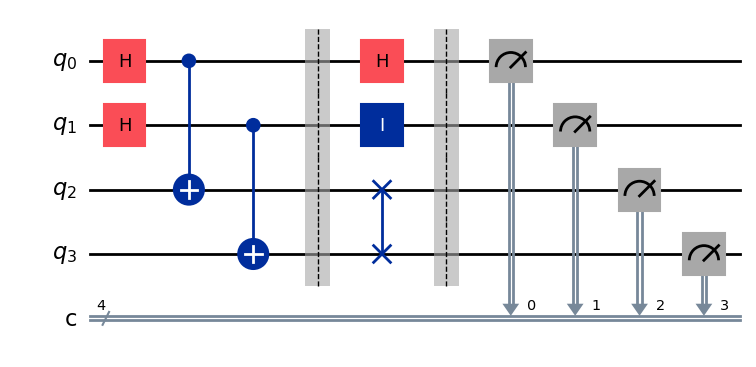

In [45]:
#We will ask the user to select the row and column on Alice and Bob's behalf.
print("Alice and Bob, select a column or row value of 1, 2, or 3") 
print("Alice choice (column):")
alpha = int(input())
print(alpha)
print("Bob choice (row):")
beta = int(input())
print(beta)

#Create the circuit
magicsquare_circuit = QuantumCircuit(4,4)

#Generate the Bell state on the circuit
share_bell_state(magicsquare_circuit,0,1,2,3)

magicsquare_circuit.barrier()

#Draw the rest of the circuit based on Alice and Bob's selection   
if 4>alpha>0 and 4>beta>0:
    U(magicsquare_circuit,alpha,0,1) 
    V(magicsquare_circuit,beta,2,3)
    magicsquare_circuit.barrier()
    magicsquare_circuit.measure(0,0)
    magicsquare_circuit.measure(1,1)
    magicsquare_circuit.measure(2,2)
    magicsquare_circuit.measure(3,3)
    
    magicsquare_circuit.draw(output='mpl')
    #print(magicsquare_circuit)

    backend = AerSimulator() # define the backend
    sampler = Sampler(mode=backend)
    sampler.options.default_shots=8192
    counts = sampler.run([magicsquare_circuit]).result()[0].data.c.get_counts()
    check_result(counts, alpha, beta)
    print(counts)

else:
    print("please enter values of 1, 2, or 3")